In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise
import random

In [2]:
def ybusppg(num):
## Creation of y bus
    
    linedata = linedatas(7); # Calling "linedata6.m" for Line Data...
    fb = linedata[:,0];     # From bus number... i.e in the column 1
    tb = linedata[:,1];     # To bus number...
    r = linedata[:,2];      # Resistance, R...
    x = linedata[:,3];      # Reactance, X...
    b = linedata[:,4];      # Ground Admittance, B/2...
    a = linedata[:,5];      # Tap setting value..
    z = r + x*1j;            # Z matrix...
    y = 1/z;               # To get inverse of each element...
    b = b*1j;                # Make B imaginary...

    nbus = int(np.max([np.max(fb),np.max(tb)]));                # no. of buses...
    nbranch = len(fb)                                           # no. of branches...
    ybus = np.mat(np.zeros((nbus,nbus), dtype=complex));       # Initialise YBus...
    
    # Formation of the Off Diagonal Elements...
    # Formation of the Off Diagonal Elements...
    for k in range (0,nbranch):
        ybus[int(fb[k]-1),int(tb[k]-1)] =ybus[int(fb[k]-1),int(tb[k]-1)]- (y[k]/a[k]);
        ybus[int(tb[k]-1),int(fb[k]-1)] = ybus[int(fb[k]-1),int(tb[k]-1)];
 
 
    # Formation of Diagonal Elements....
    for m in range (0,nbus):
        for n in range (0,nbranch):
            if fb[n]-1 == m:
                ybus[m,m]=ybus[m,m]+ (y[n]/(a[n]**2)) + b[n]
            elif tb[n]-1 ==m:
                ybus[m,m]=ybus[m,m]+y[n]
                

    return ybus
            
        
    

In [3]:
def bbusppg(num):     # Returns B-bus..

    linedata = linedatas(num);
    fb = linedata[:,0];  #first column 
    tb = linedata[:,1];  #2nd column 
    b = linedata[:,4];   #5th column
    nbus = int(np.max([np.max(fb),np.max(tb)]))    # no. of buses...
    nbranch = len(fb);           # no. of branches...
    bbus = np.mat(np.zeros((nbus,nbus)));

    for k in range (0,nbranch):
        bbus[int(fb[k]-1),int(tb[k]-1)] = b[k]
        bbus[int(tb[k]-1),int(fb[k]-1)] = bbus[int(fb[k]-1),int(tb[k]-1)];

    return bbus
# Traditional Measurement Data..
# Vi - 1, Pi - 2, Qi - 3, Pij - 4, Qij - 5, Iij - 6],

In [4]:
def Hx(x):

    num=7;
    del_T=0.001;
    ybus = ybusppg(num); # Get YBus..
    zdata = zdatas(1); # Get Measurement data..
    
    #in every iteration we take a new row to consider from the csv file we imported
    
    bpq = bbusppg(num); # Get B data..
    nbus = int(np.max([np.max(zdata[:,3]),np.max(zdata[:,4])])); # Get number of buses..
    type1 = zdata[:,1]; # Type of measurement, Vi - 1, Pi - 2, Qi - 3, Pij - 4, Qij - 5, Iij - 6..
    z = zdata[:,2]; # Measuement values..
    fbus = zdata[:,3]; # From bus..
    tbus = zdata[:,4]; # To bus..
    Ri = np.diagflat(zdata[:,5]) # Measurement Error..
   
    G = ybus.real;
    B = ybus.imag 
    E = np.matrix(np.concatenate((del1[1:], V)))# E is the state matrix of 13*1

    vi = np.mat((type1 == 1).nonzero())[0,:] # Index of measurements..
    ppi = np.mat((type1 == 2).nonzero())[0,:]
    qi = np.mat((type1 == 3).nonzero())[0,:]
    pf = np.mat((type1 == 4).nonzero())[0,:]
    qf = np.mat((type1 == 5).nonzero())[0,:]

    nvi = vi.shape[1]; # Number of Voltage measurements..
    npi = ppi.shape[1]; # Number of Real Power Injection measurements..
    nqi = qi.shape[1]; # Number of Reactive Power Injection measurements..
    npf = pf.shape[1]; # Number of Real Power Flow measurements..
    nqf = qf.shape[1]; # Number of Reactive Power Flow measurements..

    h1 = np.mat(V[int(fbus[vi])-1,0]);
    h2 = np.mat(np.zeros((npi,1)));
    h3 = np.mat(np.zeros((nqi,1)));
    h4 = np.mat(np.zeros((npf,1)));
    h5 = np.mat(np.zeros(((nqf,1))));
    

    for i in range(0,npi):
        m = int(fbus[(ppi[0,i])])-1
        for k in range(0,nbus):
            h2[i] += V[m]*V[k]*(G[m,k]*np.cos(del1[m]-del1[k]) + B[m,k]*np.sin(del1[m]-del1[k]))

    for i in range(0,nqi):
        m = int(fbus[(qi[0,i])])-1
        for k in range(0,nbus):
            h3[i] += V[m]*V[k]*((G[m,k]*np.sin(del1[m]-del1[k])) - (B[m,k]*np.cos(del1[m]-del1[k])))

    for i in range(0,npf):
        m = int(fbus[(pf[0,i])])-1
        n = int(tbus[(pf[0,i])])-1
        h4[i] = -(V[m]**2)*G[m,n] - V[m]*V[n]*(-G[m,n]*np.cos(del1[m]-del1[n]) - B[m,n]*np.sin(del1[m]-del1[n]))

    for i in range(0,nqf):
        m = int(fbus[(qf[0,i])])-1
        n = int(tbus[(qf[0,i])])-1
        h5[i] = -(V[m]**2)*(-B[m,n]+bpq[m,n]) - V[m]*V[n]*(-G[m,n]*np.sin(del1[m]-del1[n]) + B[m,n]*np.cos(del1[m]-del1[n]))

    h=np.mat(np.concatenate((h1,h2,h3,h4,h5)))
    
    return h

In [5]:
def zdatas(i):

    Pow_i= Pi[i]; 


    #           |Msnt |Type | Value | From |   To |   Rii | 
    zdata7= np.mat([ #---- Voltage Magnitude ------------#
                [1,    1,    (Pow_i[0]/13.2)*1.732,   1,       0,   9e-4],
                # #-----------------------------------#
                # #---- Real Power Injection ---------#
                [2,    2,    Pow_i[1]/10,   3,       0,   1e-4],
                [3,    2,    Pow_i[2]/10,   5,       0,   1e-4], 
                [4,    2,    Pow_i[3]/10,   7,       0,   1e-4],
                #------------------------------------#
                #---- Reative Power Injection -------#
                [5,     3,    Pow_i[4]/10,   3,       0,   1e-4],
                [6,     3,    Pow_i[5]/10,   5,       0,   1e-4], 
                [7,     3,    Pow_i[6]/10,   7,       0,   1e-4],
                #------------------------------------#
                #------ Real Power Flow ------------- #
                [8,     4,   Pow_i[7]/10,   1,       2,   64e-6],
                [9,     4,   Pow_i[8]/10,   2,       3,   64e-6],
                [10,     4,  Pow_i[9]/10,   3,       4,   64e-6],
                [11,     4,  Pow_i[10]/10,   3,       7,   64e-6],
                [12,     4,  Pow_i[11]/10,   2,       6,   64e-6],
                [13,     4,  Pow_i[12]/10,   6,       5,   64e-6],
                [14,     4,  Pow_i[13]/10,   7,       6,   64e-6],
                #------------------------------------#
                #------ Reactive Power Flow ---------#   
                [15,     5,  Pow_i[14]/10,   1,       2,   64e-6],
                [16,     5,  Pow_i[15]/10,   2,       3,   64e-6],
                [17,     5,  Pow_i[16]/10,   3,       4,   64e-6],
                [18,     5,  Pow_i[17]/10,   3,       7,   64e-6],
                [19,     5,  Pow_i[18]/10,   2,       6,   64e-6],
                [20,     5,  Pow_i[19]/10,   6,       5,   64e-6],
                [21,     5,  Pow_i[20]/10,   7,       6,   64e-6]])
    return zdata7

In [6]:

def  linedatas(num):
    ## 
    #         |  From |  To   |   R     |   X     |     B/2  |  X'mer  |
    #         |  Bus  | Bus   |  pu     |  pu     |     pu   | TAP (a) |
    linedata7=np.mat([  [1,      2,       0.07149,   0.17840,       0.0,       1],
                        [2,      3,       0.00596,   0.01487,       0.0,       1],
                        [2,      6,       0.01291,   0.03221,       0.0,       1],
                        [3,      4,       0.02284,   0.05699,       0.0,       1],
                        [3,      7,       0.00496,   0.01239,       0.0,       1],
                        [6,      5,       0.01688,   0.04209,       0.0,       1],
                        [6,      7,       0.01390,   0.03469,       0.0,       1]])
    
    return linedata7

In [7]:
def HJacobian_at1(x):
    num=7;
    del_T=0.001;
    ybus = ybusppg(num); # Get YBus..
    zdata = zdatas(1); # Get Measurement data..
    
    #in every iteration we take a new row to consider from the csv file we imported
    
    bpq = bbusppg(num); # Get B data..
    nbus = int(np.max([np.max(zdata[:,3]),np.max(zdata[:,4])])); # Get number of buses..
    type1 = zdata[:,1]; # Type of measurement, Vi - 1, Pi - 2, Qi - 3, Pij - 4, Qij - 5, Iij - 6..
#     z = zdata[:,2]; # Measuement values..
    fbus = zdata[:,3]; # From bus..
    tbus = zdata[:,4]; # To bus..
    Ri = np.diagflat(zdata[:,5]) # Measurement Error..
   
    G = ybus.real;
    B = ybus.imag 
    E = np.matrix(np.concatenate((del1[1:], V)))# E is the state matrix of 13*1

    vi = np.mat((type1 == 1).nonzero())[0,:] # Index of measurements..
    ppi = np.mat((type1 == 2).nonzero())[0,:]
    qi = np.mat((type1 == 3).nonzero())[0,:]
    pf = np.mat((type1 == 4).nonzero())[0,:]
    qf = np.mat((type1 == 5).nonzero())[0,:]

    nvi = vi.shape[1]; # Number of Voltage measurements..
    npi = ppi.shape[1]; # Number of Real Power Injection measurements..
    nqi = qi.shape[1]; # Number of Reactive Power Injection measurements..
    npf = pf.shape[1]; # Number of Real Power Flow measurements..
    nqf = qf.shape[1]; # Number of Reactive Power Flow measurements..
    H11=np.mat(np.zeros((nvi,nbus-1)))

    H12=np.mat(np.zeros((nvi,nbus)))
    for k in range(0,nvi):
        for n in range(0,nvi):
            if n == k:
                 H12[k,n]=1

    H21=np.mat(np.zeros((npi,nbus-1)))
    for i in range(0,npi):
        m = int(fbus[(ppi[0,i])])-1
        for k in range(0,nbus-1):
            if k+1 == m:
                for n in range(0,nbus):
                    H21[i,k] += V[m]*V[n]*(-G[m,n]*np.sin(del1[m]-del1[n]) + B[m,n]*np.cos(del1[m]-del1[n]))
                H21[i,k] -= (V[m]**2)*B[m,m]
            else:
                H21[i,k]=V[m]*V[k+1]*(G[m,k+1]*np.sin(del1[m]-del1[k+1]) - B[m,k+1]*np.cos(del1[m]-del1[k+1]))

    H22=np.mat(np.zeros((npi,nbus)))
    for i in range(0,npi):
        m = int(fbus[(ppi[0,i])])-1
        for k in range(0,nbus):
            if k == m:
                for n in range(0,nbus):
                    H22[i,k] += V[n]*(G[m,n]*np.cos(del1[m]-del1[n]) + B[m,n]*np.sin(del1[m]-del1[n]))
                H22[i,k] += V[m]*G[m,m]
            else:
                H22[i,k]=V[m]*(G[m,k]*np.cos(del1[m]-del1[k]) + B[m,k]*np.sin(del1[m]-del1[k]))

    H31=np.mat(np.zeros((nqi,nbus-1)))
    for i in range(0,nqi):
        m = int(fbus[(qi[0,i])])-1
        for k in range(0,nbus-1):
            if k+1 == m:
                for n in range(0,nbus):
                     H31[i,k] += V[m]*V[n]*(G[m,n]*np.cos(del1[m]-del1[n]) + B[m,n]*np.sin(del1[m]-del1[n]))
                H31[i,k] -= (V[m]**2)*G[m,m]
            else:
                H31[i,k]=V[m]*V[k+1]*(-G[m,k+1]*np.cos(del1[m]-del1[k+1]) - B[m,k+1]*np.sin(del1[m]-del1[k+1]))


    H32=np.mat(np.zeros((nqi,nbus)))
    for i in range(0,nqi):
        m = int(fbus[(qi[0,i])])-1
        for k in range(0,nbus):
            if k == m:
                for n in range(0,nbus):
                     H32[i,k] += V[n]*(G[m,n]*np.sin(del1[m]-del1[n]) - B[m,n]*np.cos(del1[m]-del1[n]))
                H32[i,k] -= V[m]*B[m,m]
            else:
                H32[i,k]=V[m]*(G[m,k]*np.sin(del1[m]-del1[k]) - B[m,k]*np.cos(del1[m]-del1[k]))

    H41=np.mat(np.zeros((npf,nbus-1)))
    for i in range(0,npf):
        m = int(fbus[(pf[0,i])])-1
        n = int(tbus[(pf[0,i])])-1
        for k in range(0,nbus-1):
            if k+1 == m:
                H41[i,k] = V[m]*V[n]*(-G[m,n]*np.sin(del1[m]-del1[n]) + B[m,n]*np.cos(del1[m]-del1[n]))
            elif k+1 == n:
                H41[i,k] = -V[m]*V[n]*(-G[m,n]*np.sin(del1[m]-del1[n]) + B[m,n]*np.cos(del1[m]-del1[n]))
            else:
                H41[i,k] = 0
        H42=np.mat(np.zeros((npf,nbus)))
    for i in range(0,npf):
        m = int(fbus[(pf[0,i])])-1
        n = int(tbus[(pf[0,i])])-1
        for k in range(0,nbus):
            if k == m:
                H42[i,k] = -V[n]*(-G[m,n]*np.cos(del1[m]-del1[n]) - B[m,n]*np.sin(del1[m]-del1[n])) -2*G[m,n]*V[m]
            elif k == n:
                H42[i,k] = -V[m]*(-G[m,n]*np.cos(del1[m]-del1[n]) - B[m,n]*np.sin(del1[m]-del1[n]))
            else:
                H42[i,k] = 0

    H51=np.mat(np.zeros((nqf,nbus-1)))
    for i in range(0,nqf):
        m = int(fbus[(qf[0,i])])-1
        n = int(tbus[(qf[0,i])])-1
        for k in range(0,nbus-1):
            if k+1 == m:
                 H51[i,k] = -V[m]*V[n]*(-G[m,n]*np.cos(del1[m]-del1[n]) - B[m,n]*np.sin(del1[m]-del1[n]))
            elif k+1 == n:
                H51[i,k] = V[m]*V[n]*(-G[m,n]*np.cos(del1[m]-del1[n]) - B[m,n]*np.sin(del1[m]-del1[n]))
            else:
                H51[i,k] = 0
    

    H52=np.mat(np.zeros((nqf,nbus)))
    for i in range(0,nqf):
        m = int(fbus[(qf[0,i])])-1
        n = int(tbus[(qf[0,i])])-1
        for k in range(0,nbus):
            if k == m:
                H52[i,k] = -V[n]*(-G[m,n]*np.sin(del1[m]-del1[n]) + B[m,n]*np.cos(del1[m]-del1[n])) -2*V[m]*(-B[m,n]+bpq[m,n])
            elif k == n:
                H52[i,k] = -V[m]*(-G[m,n]*np.sin(del1[m]-del1[n]) + B[m,n]*np.cos(del1[m]-del1[n]))
            else:
                H52[i,k] = 0

    H1=np.mat(np.concatenate((H11,H12),axis=1))
    H2=np.mat(np.concatenate((H21,H22),axis=1))
    H3=np.mat(np.concatenate((H31,H32),axis=1))
    H4=np.mat(np.concatenate((H41,H42),axis=1))
    H5=np.mat(np.concatenate((H51,H52),axis=1))

    H=np.mat(np.concatenate((H1,H2,H3,H4,H5)))
    
    return H
    

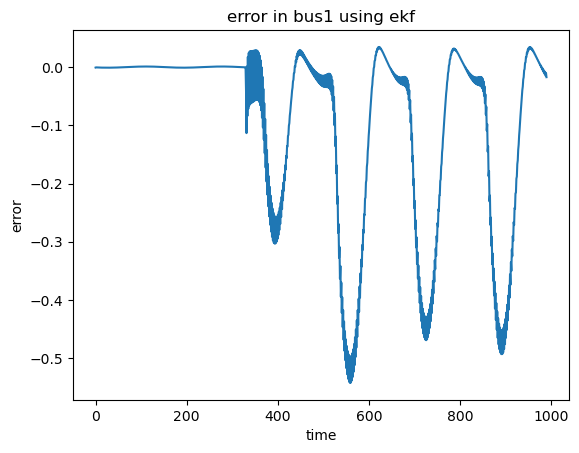

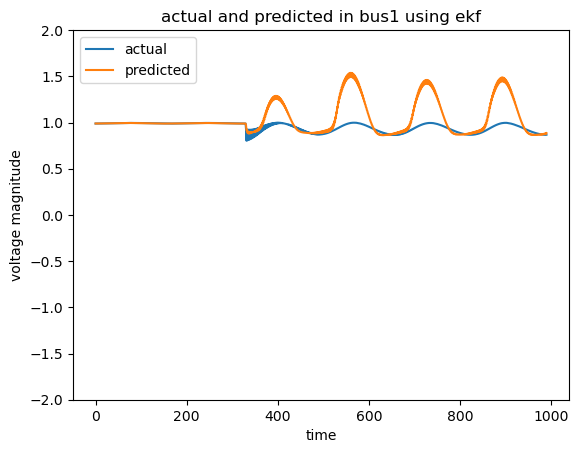

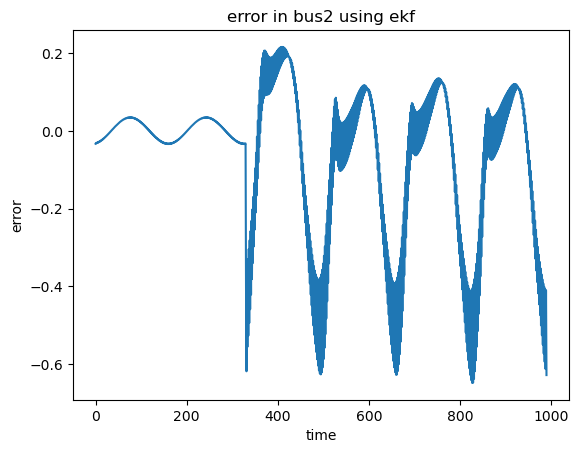

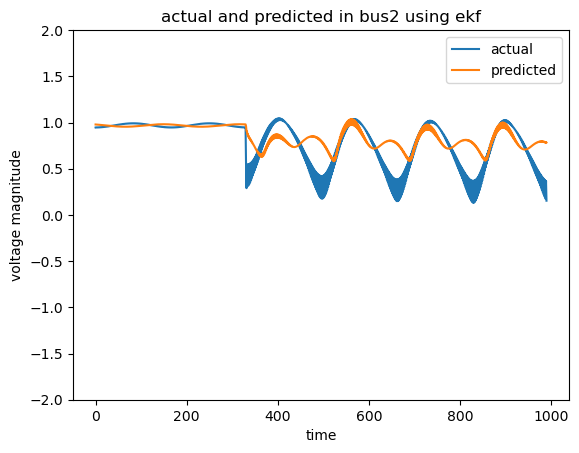

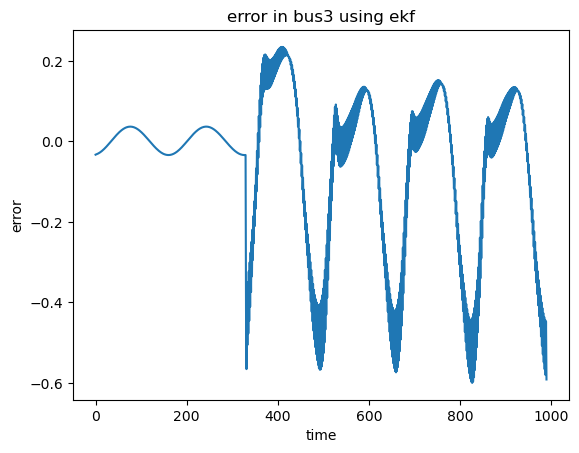

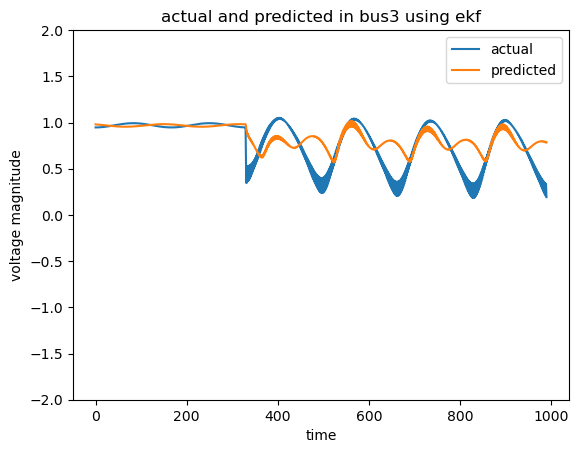

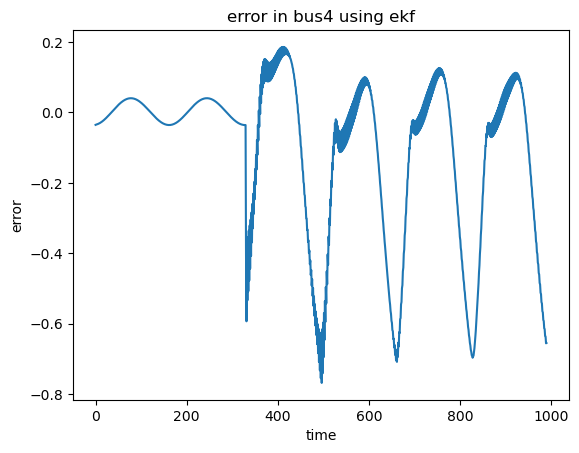

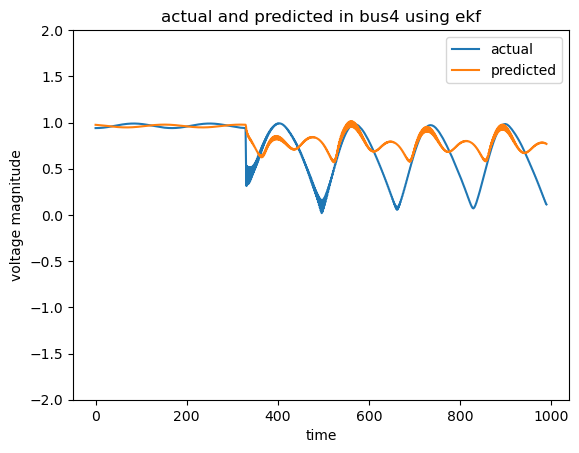

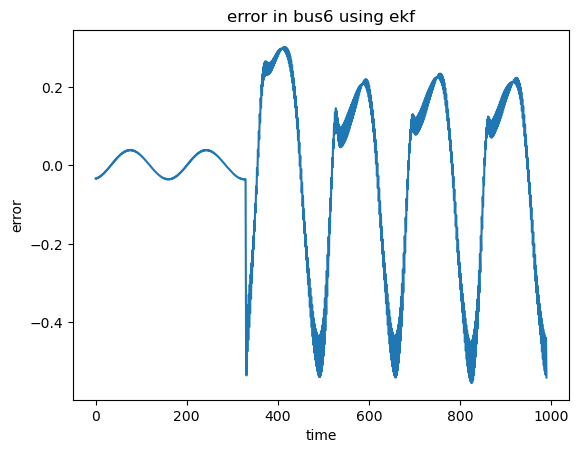

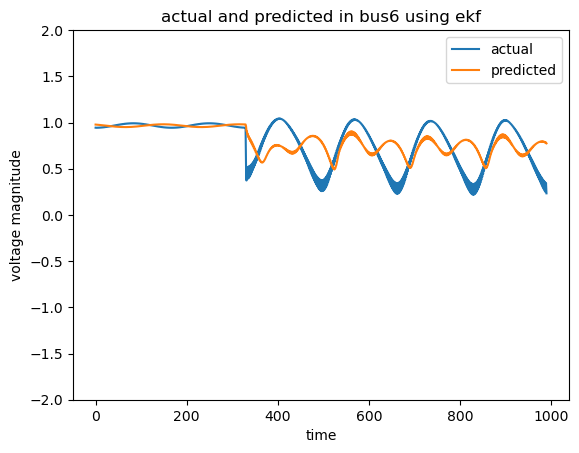

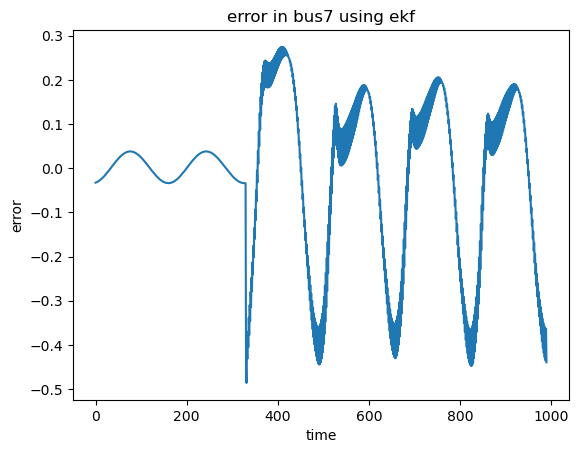

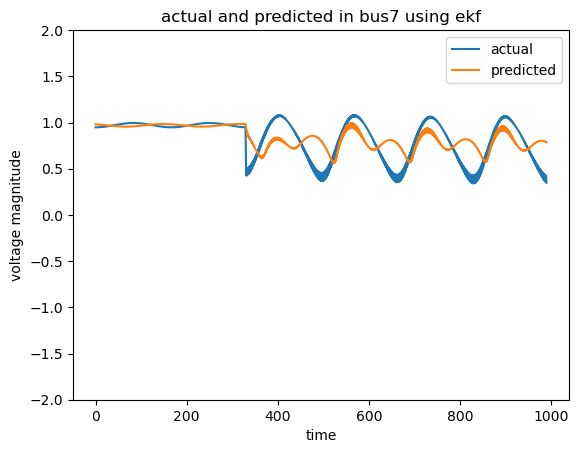

In [47]:
## -------------------the actual code  ------------------##
## -------------------steady state  ------------------##
# Pi= pd.read_csv("Data/_gc_ss_newmodel.csv_modified.csv")
# df=pd.read_csv("Data/Vrms_gc_ss_newmodel_modified.csv")

## -------------------fault case  ------------------##
Pi= pd.read_csv("Data/_gc_fault3_newmodel_modified.csv")
df=pd.read_csv("Data/Vrms_gc_fault3_newmodel_modified.csv")

## -------------------topo case  ------------------##
# Pi= pd.read_csv("Data/_gc_topo3_newmodel_modified.csv")
# df=pd.read_csv("Data/Vrms_gc_topo3_newmodel_modified.csv")
Pi= Pi.to_numpy();
Pi=Pi;
nbus=7;
# Pi= Pi.to_numpy();
# Pi=Pi;
num=7






zdata = zdatas(2)
# R1=zdata[:,5]
Y_V= [0]*7;
Y_D= [0]*7;
V = np.ones((nbus,1)) # Initialize the bus voltages..
del1 = np.zeros((nbus,1)); # Initialize the bus angles..
E_in = np.matrix(np.concatenate((del1, V)))
P= np.eye(2*7-1);
iter = 1;
tol = 5;
R= np.eye(21) * 0.01 

ekf = ExtendedKalmanFilter(dim_x=13, dim_z=21)


initial_state = np.zeros((13, 1))  # Initial state vector
for i in range(6,13):
    initial_state[i]=1
initial_covariance = np.eye(13)*1e-1 # Initial covariance matrix

ekf.x = initial_state
ekf.P = initial_covariance

# best for fault1
# ekf.Q =np.eye(13)*1.1*1e-5 # Process noise covariance matrix
# ekf.R = np.eye(21)*7*1e-3 # Measurement noise covariance matrix

#best for topo and steady state
# ekf.Q =np.eye(13)*1e-5 # Process noise covariance matrix
# ekf.R = np.eye(21)*1e-6 # Measurement noise covariance matrix

#experimental
ekf.Q =np.eye(13)*5*1e-4 # Process noise covariance matrix
ekf.R = np.eye(21)*5*1e-4 # Measurement noise covariance matrix


def f(x, dt):
    F = np.identity(13)
    return F @ x


x_g=[]
y_g=[]
y_error=[]

y_actual=[]
y_per_error=[]
c1=0

for i2 in range(14):
    y_g.append([])
    y_error.append([])
    y_actual.append([])
    y_per_error.append([])


for i in range (0,990):
    # print(i)
    zdata = zdatas(i)
    z = zdata[:,2]
    
    
    ekf.HJacobian=HJacobian_at1
    ekf.h=Hx
    
    num_buses=7;
    ekf.F =np.identity(13);
    ekf.f=f
    
    ekf.predict()  # Prediction step using system dynamics function
    ekf.update(z,ekf.HJacobian,ekf.h)  # Update step using measurement function
    del1[1:] = ekf.x[0:nbus-1]
    V=ekf.x[nbus-1:]




    for i1 in range(0,7):
        if(i1==4):
            continue
        y11=V[i1]
        y_g[i1].append(y11.item())
        diff=(df[f'Subsystem #1|CTLs|Vars|Vrms{i1+1}'][i]/7.62)-y_g[i1][-1]
        y_error[i1].append(diff)
        y_actual[i1].append(df[f'Subsystem #1|CTLs|Vars|Vrms{i1+1}'][i]/7.62)
        abs_val=abs(diff)
        abs_val*=100
        y_per_error[i1].append((abs_val))
    x_g.append(i)
    c1+=1

    # plot.figure()
    # plot.plot(range(1,nbus+1),del1,'-r*')
    # plot.title('Voltage phase angles')
    # plot.xlabel('Bus number')
    # plot.ylabel('Phase angle (rad)')
    # plot.xlim(1,nbus)

    # plot.figure()
    # plot.plot(range(1,nbus+1),V,'-r*')
    # plot.title('Voltage ')
    # plot.xlabel('Bus number')
    # plot.ylabel('voltage in p.u')
    # plot.xlim(1,nbus)
    # print("State:\n\n", ekf.x[0:])
for i2 in range(7):
    # plot.plot(x_g,y_g[i2],label=f'bus {i2}')
    if(i2==4):
        continue
    # print(y_actual[i2][200:])
    plot.plot(x_g,y_error[i2],label=f"error")
    ax=plot.gca()
    # ax.set_ylim(-0.001756675,-0.001756650)
    plot.title(f'error in bus{i2+1} using ekf')
    plot.xlabel('time')
    plot.ylabel('error')
    plot.show()
    # plot.plot(x_g,y_per_error[i2],label=f"percentage error")
    # plot.title(f'percentage error in bus{i2+1} using ekf')
    # plot.xlabel('time')
    # plot.ylabel('percentage error')
    # plot.show()
    plot.plot(x_g,y_actual[i2],label=f"actual")
    plot.plot(x_g,y_g[i2],label=f"predicted")
    ax=plot.gca()
    ax.set_ylim(-2,2)
    plot.title(f'actual and predicted in bus{i2+1} using ekf')
    plot.xlabel('time')
    plot.ylabel('voltage magnitude')
    plot.legend()
    plot.show() 